# Сборный проект

Описание задачи

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as seaborn

# Шаг 1. Загрузка данных

In [2]:
data=pd.read_csv('/datasets/games.csv')
data.head(5)
len_data_1=data['Name'].count()

# Шаг 2. Подготовка данных

# Замена названия столбцов (приведение к нижнему регистру)

In [3]:
data.columns=data.columns.str.lower()
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Преобразование данных в нужные типы

In [4]:
data.info()
data['year_of_release'] = np.floor(pd.to_numeric(data['year_of_release'], errors='coerce')).astype('Int64')
data['critic_score'] = np.floor(pd.to_numeric(data['critic_score'], errors='coerce')).astype('Int64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Вывод: в столбцах critic_score, year_of_release изменен формат данных в int

# Обработка пропусков

In [5]:
#выведем количество ячеек с нулевыми значениями в столбцах датафрейма]
data.loc[data['user_score'] =='tbd','user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float')
data.drop(data[data['year_of_release'].isna()].index,inplace=True)
data.drop(data[data['name'].isna()].index,inplace=True)
data.loc[data.loc[:,'rating'].isnull(),'rating'] = 'нет рейтинга'
display(data.isna().sum())
len_data_2=data['name'].count()
display(100-100*len_data_2/len_data_1)

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

1.6095255190570157

Вывод: значение tbd заменено на NaN. Год релиза, оценка критиков,
пользователей и рейтинг не могут быть подставлены по медианному или среднему
значению, поэтому не были удалены или заменены на средние. Возможно оценка для каждой игры появляется на основании какого-то количества оценок пользователей и критиков, а для некоторых игр данная цифра не достигается, поэтому результирующая оценка и не отображается в датафрейме. 

tbd- расшифровывается с ангилийского "to be defined". Оценка еще не выставлена.

# Удаление дубликатов

In [6]:
display(data.shape)
data=data.drop_duplicates()
data=data.drop_duplicates(subset=['name','platform','year_of_release'])
display(data.shape)

(16444, 11)

(16443, 11)

Вывод: явные дубликаты отсутствуют в датафрейме.

# Подсчет суммарных продаж по миру

In [7]:
data['total_sales']=data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,нет рейтинга,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,нет рейтинга,31.38


# Шаг 3. Проведение исследовательского анализа данных

# Количество выпускаемых игр за все года

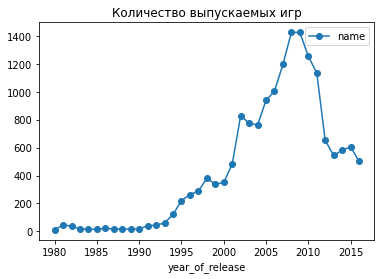

In [8]:
years=pd.pivot_table(data, index='year_of_release', values='name', aggfunc='count')
years.plot(y='name', style='-o',title='Количество выпускаемых игр')
data_2 = data.query('2013<= year_of_release <= 2016')

Вывод: По графику видно, что стоит отбросить данные до 2000 г. Актуальный
период взят за 2013-2016 гг. для последующих расчетов, т.к. индустрия игр стремительно развивается.

# Продажи по платформам

,total_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


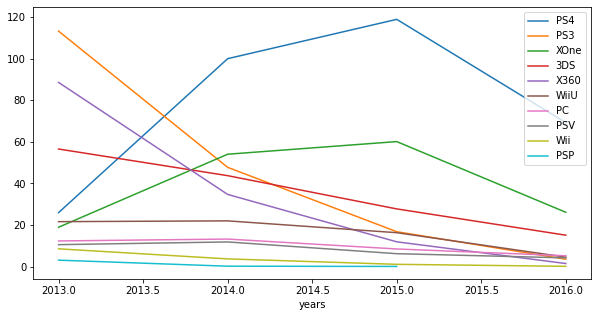

In [9]:
platforms= data_2.groupby('platform').agg({'total_sales':'sum'})
platforms=platforms.sort_values(by ='total_sales', ascending = False)
display(platforms)
top_10=platforms[:10].index
platform_pivot_table_years =data_2.pivot_table(index=['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum')
platform_pivot_table_years['years'] =  platform_pivot_table_years.index
platform_pivot_table_years['years'] = platform_pivot_table_years['years'].apply (lambda row: row[1]).astype('int')
fig, ax = plt.subplots(figsize =(10,5))
for platform in top_10:
    platform_pivot_table_years.loc[platform].plot('years','total_sales', ax=ax)
ax.legend(top_10,prop = {'size':10})
plt.show()

Вывод: по результатам обработки продаж по платформам, можно сделать вывод, что период появления самых кассовых и исчезновения старых платформ прослеживается в 2004-2006 гг. 
Потенциально прибыльной платформой может стать PS4 по состоянию на конец 2016 г.

# Глобальные продажи игр в разбивке по платформам

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

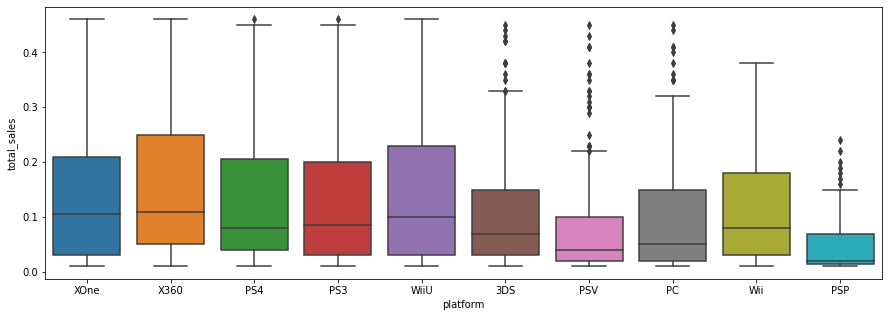

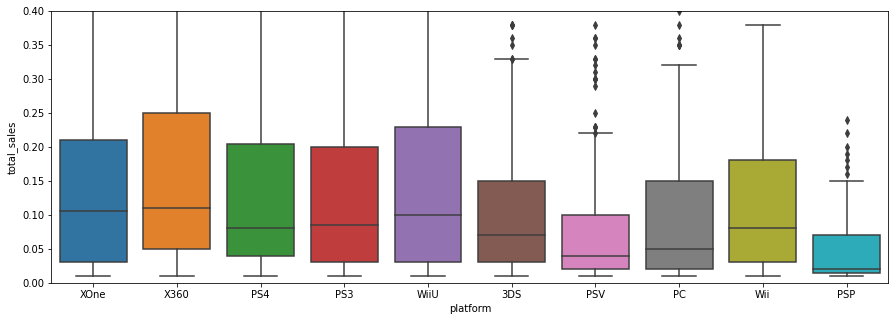

'PS4'

count    1229.000000
mean        0.551871
std         1.394033
min         0.010000
25%         0.040000
50%         0.130000
75%         0.430000
max        21.050000
Name: total_sales, dtype: float64

'PS3'

count    837.000000
mean       0.435018
std        1.264982
min        0.010000
25%        0.040000
50%        0.110000
75%        0.350000
max       21.050000
Name: total_sales, dtype: float64

'XOne'

count    2225.000000
mean        0.489506
std         1.237281
min         0.010000
25%         0.030000
50%         0.110000
75%         0.400000
max        21.050000
Name: total_sales, dtype: float64

'3DS'

count    303.000000
mean       0.472772
std        1.381347
min        0.010000
25%        0.040000
50%        0.090000
75%        0.280000
max       14.600000
Name: total_sales, dtype: float64

'X360'

count    1978.000000
mean        0.470086
std         1.259023
min         0.010000
25%         0.030000
50%         0.100000
75%         0.370000
max        21.050000
Name: total_sales, dtype: float64

'WiiU'

count    1792.000000
mean        0.442539
std         1.206616
min         0.010000
25%         0.030000
50%         0.100000
75%         0.330000
max        21.050000
Name: total_sales, dtype: float64

'PC'

count    492.000000
mean       0.371301
std        1.112517
min        0.010000
25%        0.030000
50%        0.080000
75%        0.260000
max       14.600000
Name: total_sales, dtype: float64

'PSV'

count    1654.000000
mean        0.432128
std         1.220852
min         0.010000
25%         0.030000
50%         0.090000
75%         0.300000
max        21.050000
Name: total_sales, dtype: float64

'Wii'

count    1677.000000
mean        0.434347
std         1.217119
min         0.010000
25%         0.030000
50%         0.090000
75%         0.310000
max        21.050000
Name: total_sales, dtype: float64

'PSP'

count    1296.000000
mean        0.526042
std         1.362063
min         0.010000
25%         0.040000
50%         0.120000
75%         0.400000
max        21.050000
Name: total_sales, dtype: float64

In [10]:
temp=data_2.query("platform in @top_10")
third = temp['total_sales'].quantile(0.75)
first = temp['total_sales'].quantile(0.25)
threshold = third+ 2*first
fig, ax = plt.subplots(figsize =(15,5))
seaborn.boxplot(x = 'platform', y = 'total_sales', data = temp.query('total_sales <= @threshold'),ax=ax) 
fig, ax = plt.subplots(figsize =(15,5))
plt.ylim([0, temp['total_sales'].quantile(0.75).max()])
display(seaborn.boxplot(x = 'platform', y = 'total_sales', data = temp.query('total_sales <= @threshold'),ax=ax))
plt.show()


for device in top_10:
    display(device)
    platform_describe=temp.query('platform <= @device')
    display(platform_describe['total_sales'].describe())

Вывод: Наиболее неравномерное распределение по продажам относительно медианы характерно PC. 

# Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков

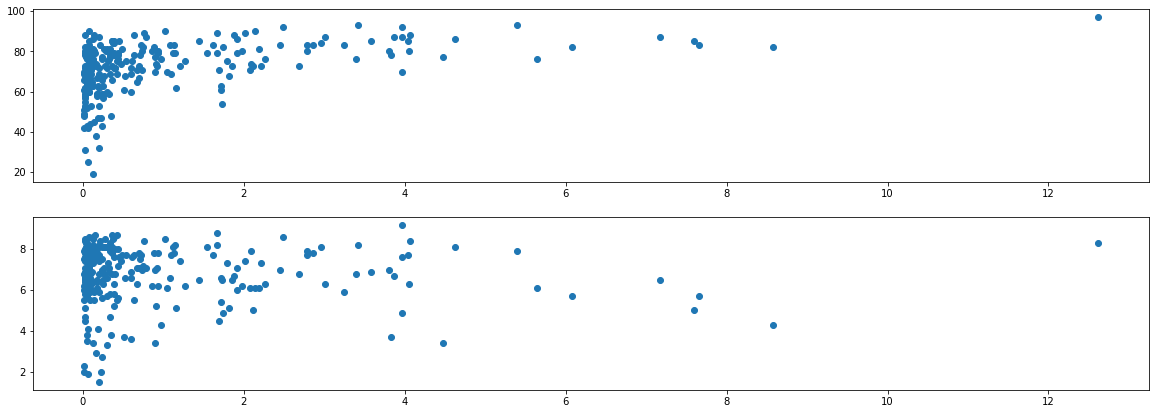

'PS4'

'корреляция между отзывами критиков и продажами '

0.40656790206178095

'корреляция между отзывами пользователей и продажами '

-0.031957110204556376

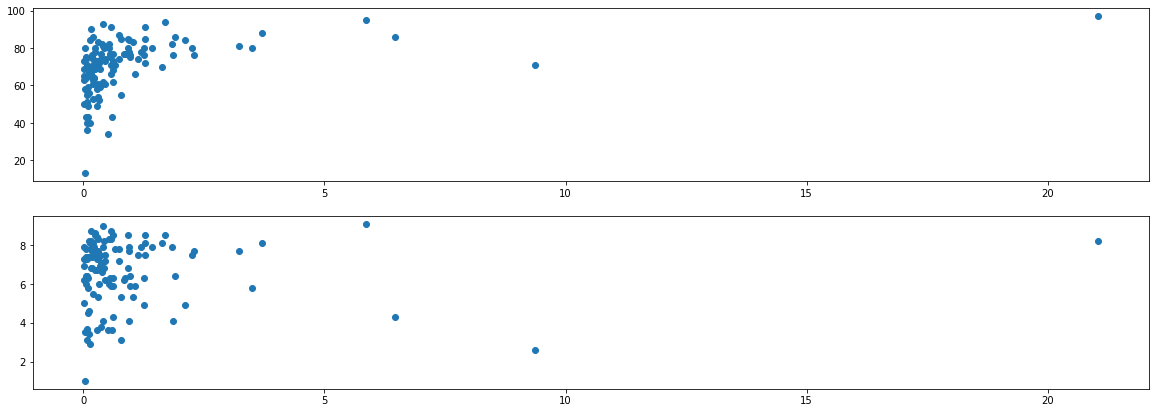

'PS3'

'корреляция между отзывами критиков и продажами '

0.3342853393371919

'корреляция между отзывами пользователей и продажами '

0.0023944027357566925

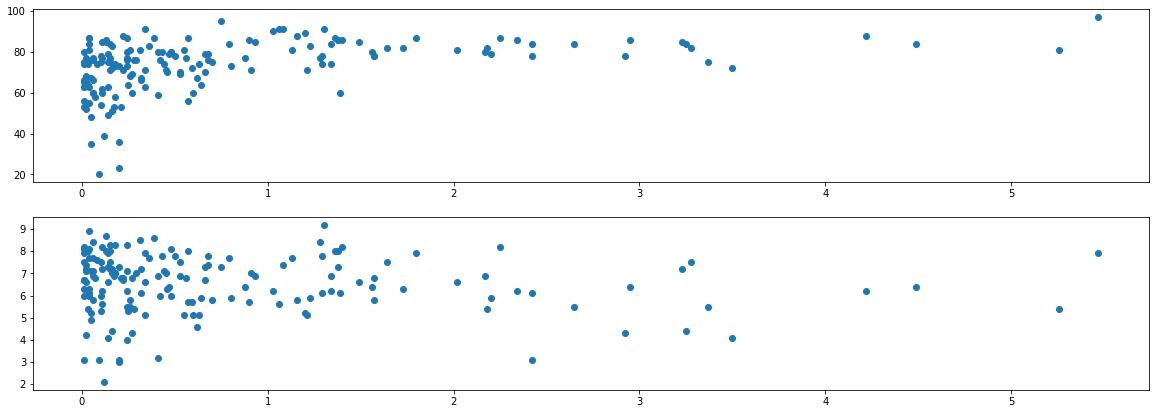

'XOne'

'корреляция между отзывами критиков и продажами '

0.4169983280084017

'корреляция между отзывами пользователей и продажами '

-0.06892505328279414

In [11]:
def marks (device,data_device):
    fig, (ax,ax2) = plt.subplots(2,1, figsize = (20,7))
    ax.scatter(y= 'critic_score', x = 'total_sales',data =data_2.query('platform==@device').dropna())
    ax2.scatter(y= 'user_score', x = 'total_sales',data =data_2.query('platform == @device').dropna())
    plt.show()
    scores= data_device.query('platform == @device')[['critic_score','user_score','total_sales']]
    scores['critic_score'] = np.floor(pd.to_numeric(scores['critic_score'], errors='coerce')).astype('float64')
    display(device)
    display('корреляция между отзывами критиков и продажами ',scores['critic_score'].corr(scores['total_sales']))
    display('корреляция между отзывами пользователей и продажами ',scores['user_score'].corr(scores['total_sales']))
    
for platform in top_10[:3]:
    marks(platform,data_2)

Вывод: Оценки критиков демонстрируют прямую, слабую положительную корреляцию с "цифрами" продаж. Оценки пользователей корреляции с продажами не имеют для всех топ-3 платформ

# Общее распределение игр по жанрам

In [12]:
genre= pd.pivot_table(data_2, index='genre', values='total_sales', aggfunc=['count','median','sum'])
genre=genre.reset_index()
genre.columns=['genre','count','median','sum']
genre=genre.sort_values(by='sum', ascending = False)
display(genre)

,genre,count,median,sum
0,Action,766,0.110,321.87
8,Shooter,187,0.450,232.98
10,Sports,214,0.240,150.65
7,Role-Playing,292,0.125,145.89
3,Misc,155,0.100,62.82
4,Platform,74,0.225,42.63
6,Racing,85,0.120,39.89
2,Fighting,80,0.125,35.31
1,Adventure,245,0.030,23.64
9,Simulation,62,0.100,21.76


Вывод: Суммы продаж наибольшие для игр жанра "Action", но медиана составляет 0,22, а для следующего по топу жанра "Shotter" составляет уже 0,605. Можно сделать вывод, что для игр жанра "Action" больше всего игр с большими продажами, но медиана меньше.

# Шаг 4. Составление портрета пользователя каждого региона

# Самые популярные платформы (топ-5)

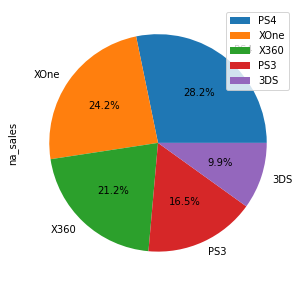

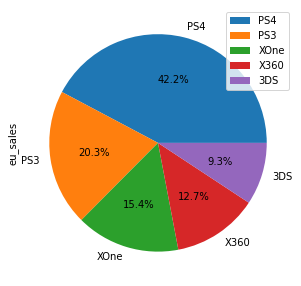

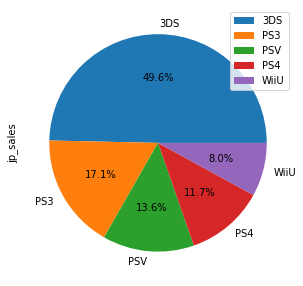

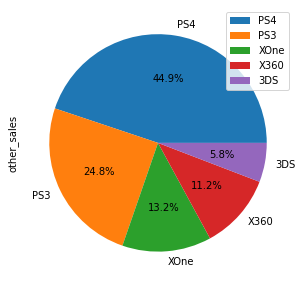

In [13]:
def platform_top5_region (region,data_frame):
    platforms= pd.pivot_table(data_frame, index='platform', values=region, aggfunc='sum')
    platforms=platforms.sort_values(by =region, ascending = False)
    top_5=platforms[:5]
    label=platforms[:5].index
    top_5.plot.pie(y=region ,labels=label,figsize=(5, 5),autopct='%1.1f%%')
    plt.show()
platform_top5_region('na_sales',data_2)
platform_top5_region('eu_sales',data_2)
platform_top5_region('jp_sales',data_2)
platform_top5_region('other_sales',data_2)

Вывод: По долям продаж наиболее продаваемых игр для платформ можно сделать вывод, что лидер на японском рынке 3DS, на остальных рынках лидер PS4.

# Самые популярные жанры (топ-5)

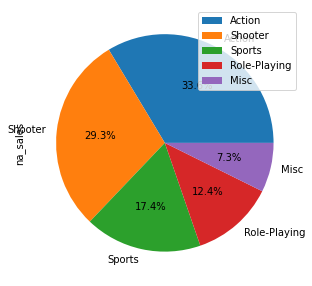

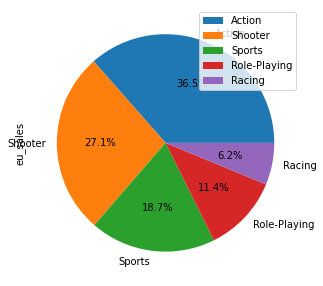

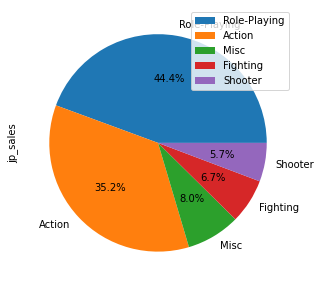

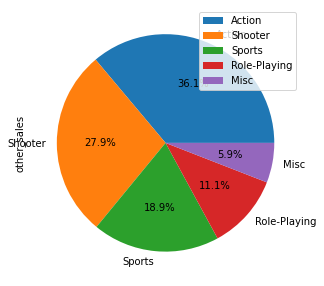

In [14]:
def genre_top5_region (region,data_frame):
    genre= pd.pivot_table(data_frame, index='genre', values=region, aggfunc='sum')
    genre=genre.sort_values(by =region, ascending = False)
    top_5=genre[:5]
    label=genre[:5].index
    top_5.plot.pie(y=region ,labels=label,figsize=(5, 5),autopct='%1.1f%%')
    plt.show()
genre_top5_region('na_sales',data_2)
genre_top5_region('eu_sales',data_2)
genre_top5_region('jp_sales',data_2)
genre_top5_region('other_sales',data_2)

Вывод: Для рынков Европы и Америки наиболее востребованы игры жанров: action, sports, shooter. Для японского же рынка характерен топ-3: role-playing, action, misc

# Оценка влияния рейтинга ESRB на продажи в отдельном регионе

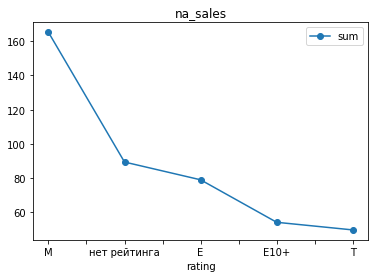

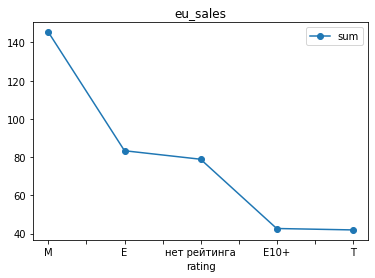

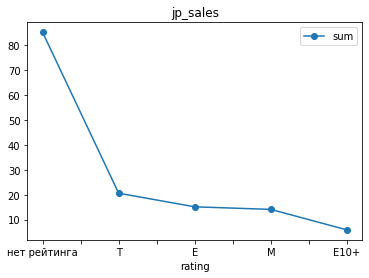

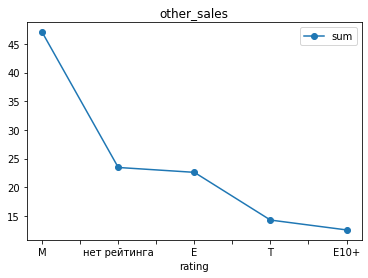

In [15]:
def rating_top5_region (region,data_frame):
    rating= pd.pivot_table(data_frame, index='rating', values=region, aggfunc='sum')
    rating=rating.sort_values(by=region, ascending = False)
    rating.columns=['sum']
    rating.plot(y='sum', style='-o',title=region)
    plt.show()
    
rating_top5_region('na_sales',data_2)
rating_top5_region('eu_sales',data_2)
rating_top5_region('jp_sales',data_2)
rating_top5_region('other_sales',data_2)

Вывод: Обьемы продаж намного больше для игр с рейтингами E,M,T, чем для игр с
рейтингом E10+. Для японского рынка много лидеров продаж без рейтинга. Можно предположить, что данные игры не выходят на мировой рынок и не оцениваются соответственно. 

# Шаг 5. Проверка гипотез

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

альтернартивная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные

In [16]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(data.query('platform == "XOne"')['user_score'],data.query('platform == "PC"')['user_score'])
print(f'p-value: {results.pvalue}')
# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: nan
Нет оснований отвергнуть нулевую гипотезу


Вывод: Средние пользовательские рейтинги платформ Xbox One и PC разные

# Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

Нулевая гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

In [17]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(data.query('genre == "Action"')['user_score'],data.query('genre == "Sports"')['user_score'])
print(f'p-value: {results.pvalue}')
# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: nan
Нет оснований отвергнуть нулевую гипотезу


Вывод: средние пользовательские рейтинги жанров Action и Sports равны

# Шаг 6. Общий вывод

Общий вывод: 

из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

в столбцах critic_score, year_of_release изменен формат данных в int

значение tbd заменено на NaN. Год релиза, оценка критиков,
пользователей и рейтинг не могут быть подставлены по медианному или среднему
значению, поэтому не были удалены или заменены на средние. Возможно оценка для каждой игры появляется на основании какого-то количества оценок пользователей и критиков, а для некоторых игр данная цифра не достигается, поэтому результирующая оценка и не отображается в датафрейме. 

tbd- расшифровывается с ангилийского "to be defined". Оценка еще не выставлена.

актуальный период взят за 2013-2016 гг. для последующих расчетов, т.к. индустрия игр стремительно развивается.

по результатам обработки продаж по платформам, можно сделать вывод, что период появления самых кассовых и исчезновения старых платформ прослеживается в 2004-2006 гг.  Потенциально прибыльной платформой может стать PS4 по состоянию на конец 2016 г.

наиболее неравномерное распределение по продажам относительно медианы характерно PC.

оценки критиков демонстрируют прямую, слабую положительную корреляцию с "цифрами" продаж. Оценки пользователей корреляции с продажами не имеют для всех топ-3 платформ

суммы продаж наибольшие для игр жанра "Action", но медиана составляет 0,22, а для следующего по топу жанра "Shotter" составляет уже 0,605. Можно сделать вывод, что для игр жанра "Action" больше всего игр с большими продажами, но медиана меньше.

по долям продаж наиболее продаваемых игр для платформ можно сделать вывод, что лидер на японском рынке 3DS, на остальных рынках лидер PS4.

для рынков Европы и Америки наиболее востребованы игры жанров: action, sports, shooter. Для японского же рынка характерен топ-3: role-playing, action, misc

обьемы продаж намного больше для игр с рейтингами E,M,T, чем для игр с
рейтингом E10+. Для японского рынка много лидеров продаж без рейтинга. Можно предположить, что данные игры не выходят на мировой рынок и не оцениваются соответственно.

средние пользовательские рейтинги платформ Xbox One и PC разные

средние пользовательские рейтинги жанров Action и Sports равны